# Word2Vec

Text data is different from image data. It is not representend as a tensor. Most of the time text is digitaly represented as a sequence of bytes and encoded using a format such as `ascii` or `utf-8`. One naive way of representing words using vector representation is to keep a vocabulary dictrionnary and assign each word a position. This position can then be used as a one-hot vector, a vector with zeros except at the position of the word index where it is set to one. This the kind of vector we previously built for the target in multi-class classification.

While such approach works in some cases, we are limitting the amount of information carried by a word, its meanings, its genre, type, into a single number. To avoid this limitation, one can build a dictionaary of words that are represented by a random vector of a certain size. This is called an embedding. This embedding can then be trained using standard gradient descent by being used in a model.

In this chapter, we explore such an embedding called [Word2Vec](https://arxiv.org/abs/1301.3781).

In [39]:
from __future__ import annotations

from collections import Counter, OrderedDict
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.manifold import TSNE
from torch import Tensor
from torch.nn import Embedding, Linear, Module, PairwiseDistance, ReLU, Sequential
from torch.optim import AdamW, Optimizer
from torch.utils.data import DataLoader, Dataset
from tqdm.notebook import tqdm
from typing import Iterator

import matplotlib.pyplot as plt
import os
import torch
import torch.nn.functional as F
import requests

%matplotlib inline

## Harry Potter

For the sake of this exploration let us use the Harry Potter Books by J.K. Rowling. The links used for downlaoding the book content are being made available for educational purposes. Please do not use them for other usage.

The following class handles the dataset downloading, merging into a single text file, and its reading.

In [2]:
class HarryPotterBooks:
    base = "https://raw.githubusercontent.com/formcept/whiteboard/master/nbviewer/notebooks/data/harrypotter"
    urls = [
        os.path.join(base, "Book%201%20-%20The%20Philosopher's%20Stone.txt"),
        os.path.join(base, "Book%202%20-%20The%20Chamber%20of%20Secrets.txt"),
        os.path.join(base, "Book%203%20-%20The%20Prisoner%20of%20Azkaban.txt"),
        os.path.join(base, "Book%204%20-%20The%20Goblet%20of%20Fire.txt"),
        os.path.join(base, "Book%205%20-%20The%20Order%20of%20the%20Phoenix.txt"),
        os.path.join(base, "Book%206%20-%20The%20Half%20Blood%20Prince.txt"),
        os.path.join(base, "Book%207%20-%20The%20Deathly%20Hallows.txt"),
    ]

    def __init__(self, path: str, download: bool = True) -> None:
        self.path = path
        if download: self._download()

    def _download(self) -> None:
        if not os.path.isfile(self.path):
            with open(self.path, "a") as fp:
                for hp_book_url in self.urls:
                    request = requests.get(hp_book_url, allow_redirects=True)
                    fp.write(request.content.decode("utf-8"))

    def read_lines(self) -> list[str]:
        with open(self.path, "r") as fp:
            return fp.readlines()

Here we can read the first 10 lines of Harry Potter. As we can observe, we may need to clean the content before using it.

In [3]:
hp_lines = HarryPotterBooks(os.path.join(".datasets", f"hp.txt"), download=True).read_lines()
hp_lines[:10]

['/ \n',
 '\n',
 '\n',
 '\n',
 '\n',
 'THE BOY WHO LIVED \n',
 '\n',
 'Mr. and Mrs. Dursley, of number four, Privet Drive, \n',
 'were proud to say that they were perfectly normal, \n',
 'thank you very much. They were the last people you’d \n']

## Preprocessing

Text is quite a versatile data type. A same word can be used with different meanings, some can be expressed using shortened formats such as abreviations, and more. To make our work easier, let us remove some of this complexity.

The following helper class provides methods for removing, cleaning but also joining all the lines into a single welle defined string.

In [4]:
class HarryPotterLinePreprocessor:
    @staticmethod
    def remove_empty_lines(lines: Iterator[str]) -> Iterator[str]:
        return filter(lambda l: l not in ["/ \n", "\n"], lines)

    @staticmethod
    def remove_chapter_names(lines: Iterator[str]) -> Iterator[str]:
        return filter(lambda l: sum((c.isupper() or c in [" ", "\n"] for c in l)) != len(l), lines)

    @staticmethod
    def remove_page_declaration(lines: Iterator[str]) -> Iterator[str]:
        return filter(lambda l: not l.startswith("Page | "), lines)

    @staticmethod
    def replace_abbreviations(lines: Iterator[str]) -> Iterator[str]:
        return map(lambda l: l\
            .replace("Jr.", "Junior")\
            .replace("Sr.", "Senior")\
            .replace("Mr.", "Mister")\
            .replace("Mrs.", "Miss")\
            .replace("Dr.", "Doctor"),
        lines)

    def remove_end_of_line(lines: Iterator[str]) -> Iterator[str]:
        return map(lambda l: l.replace("\n", "").strip(), lines)

    @staticmethod
    def preprocess(lines: Iterator[str], join: bool = True) -> Iterator[str] | str:
        lines = HarryPotterLinePreprocessor.remove_empty_lines(lines)
        lines = HarryPotterLinePreprocessor.remove_chapter_names(lines)
        lines = HarryPotterLinePreprocessor.remove_page_declaration(lines)
        lines = HarryPotterLinePreprocessor.replace_abbreviations(lines)
        lines = HarryPotterLinePreprocessor.remove_end_of_line(lines)
        return " ".join(lines) if join else list(lines)

Here we can observe the first thousand characters of the joined and cleaned string.

In [5]:
hp_raw = HarryPotterLinePreprocessor.preprocess(hp_lines, join=True)
hp_raw[:1_000]

'Mister and Miss Dursley, of number four, Privet Drive, were proud to say that they were perfectly normal, thank you very much. They were the last people you’d expect to be involved in anything strange or mysterious, because they just didn’t hold with such nonsense. Mister Dursley was the director of a firm called Grunnings, which made drills. He was a big, beefy man with hardly any neck, although he did have a very large mustache. Miss Dursley was thin and blonde and had nearly twice the usual amount of neck, which came in very useful as she spent so much of her time craning over garden fences, spying on the neighbors. The Dursley s had a small son called Dudley and in their opinion there was no finer boy anywhere. The Dursleys had everything they wanted, but they also had a secret, and their greatest fear was that somebody would discover it. They didn’t think they could bear it if anyone found out about the Potters. Miss Potter was Miss Dursley’s sister, but they hadn’t met for sever

## Tokens

In order to build a dictionnary for our embedding, we need to split the text in single word units called tokens. The text is first split into sentences. The reason is explained later in the document.

THe following processor class provides functions to split the text into sentences, then into tokens, but also removes the english punctuation symbols, makes each token lower case to avoid repetition, and keeps the sentences that have a minimum given length (number of tokens).

In [6]:
class HarryPotterProcessor:
    @staticmethod
    def extract_sentences(raw: str) -> list[str]:
        return sent_tokenize(raw, language="english")

    @staticmethod
    def extract_sentences_tokens(sentences: list[str], min_seq: int) -> list[list[str]]:
        return list(filter(lambda s: len(s) >= 9, map(word_tokenize, sentences)))

    @staticmethod
    def to_lower(sentences_tokens: list[list[str]]) -> list[list[str]]:
        return [[t.lower() for t in s] for s in sentences_tokens]

    def lemmatize(sentences_tokens: list[list[str]]) -> list[list[str]]:
        lemmatizer = WordNetLemmatizer()
        return [[lemmatizer.lemmatize(t) for t in s] for s in sentences_tokens]

    def remove_stop_words(sentences_tokens: list[list[str]]) -> list[list[str]]:
        stop_words = set(stopwords.words('english'))
        stop_words.update([
            ".", ",", ":", ";", "?", "!",
            "(", ")", "#", "—", "-", "_", "--", "...",
            "“", "”", "\"", "'", "`", "~", "’", "|",
        ])
        return [[t for t in s if t not in stop_words] for s in sentences_tokens]

    @staticmethod
    def extract(raw: str, min_seq: int = 9) -> list[list[str]]:
        sentences = HarryPotterProcessor.extract_sentences(raw)
        sentences_tokens = HarryPotterProcessor.extract_sentences_tokens(sentences, min_seq)
        sentences_tokens = HarryPotterProcessor.to_lower(sentences_tokens)
        sentences_tokens = HarryPotterProcessor.remove_stop_words(sentences_tokens)
        sentences_tokens = HarryPotterProcessor.lemmatize(sentences_tokens)
        return sentences_tokens

## Vocabulary

The vocabulary is an augmented dictionary containing the index of every token in a given token list. It provides methods to transform a token, a string, into its index in the dictionary, and the inverse operation to transform an index to its corresponding token. Here the vocabulary only keeps the token that appears at least some given number of time in the text. It let us avoid creating an enormous dataset that woul be impracticable later.

In [7]:
class Vocab:
    def __init__(self, tokens: list[str], min_freq: int) -> None:
        self.t2f = OrderedDict(Counter(tokens).most_common())
        self._stoi = {s: i for i, (s, count) in enumerate([("<unk>", min_freq)] + list(self.t2f.items())) if count >= min_freq}
        self._itos = {i: s for s, i in self._stoi.items()}

    def __len__(self) -> int: return len(self._stoi)
    def stoi(self, s: str) -> int: return self._stoi.get(s, 0)
    def itos(self, i: int) -> int: return self._itos.get(i, "<unk>")

## Continous Bag of Words (CBOW)

A word can be explained by its surrounding, the context. Gvien a sentence, if one word is removes, it is likely you are able to find the missing one. This is due to the word surrounding the one masked. It gives us information that allows to narrow down the posibilities to a few. This is called a prior. Continuous Bag of Word (CBOW) is an embedding training method making use of this phenomena. Instead of encoding the word embedding into a latent variable and decoding it to find the input embedding back, it uses the context word as inputs that are aggregated, encoded into a latent variable that is then decoded into the target word.

The Harry Potter CBOW Dataset class is reponsible for building a dataset of context annd target word pairs. It first builds a vocabulary dictionary out of the Harry Potter Books content and uses it to output tokens as interger indices.

In [8]:
class HarryPotterCBOWDataset(Dataset):
    def __init__(self, raw: str, window_size: int, min_word_freq: int) -> None:
        super().__init__()
        assert window_size // 2 != 0
        self.raw = raw
        self.window_size = window_size
        self.min_word_freq = min_word_freq
        self.vocab: Vocab() = None
        self.pairs: list[tuple[list[str], str]] = []
        self._build()

    def _build(self) -> None:
        sentences_tokens = HarryPotterProcessor.extract(self.raw, min_seq=self.window_size + 1)
        self.vocab = Vocab((t for s in sentences_tokens for t in s), self.min_word_freq)
        for sentence_tokens in sentences_tokens:
            for start in range(len(sentence_tokens) - self.window_size):
                end = start + self.window_size
                mid = (end - start) // 2 + 1
                window = sentence_tokens[start:end]
                self.pairs.append((window[:mid] + window[mid + 1:], window[mid]))

    def __len__(self) -> int:
        return len(self.pairs)

    def __getitem__(self, idx: int) -> tuple[Tensor, int]:
        ctx, word = self.pairs[idx]
        ctx = torch.tensor([self.vocab.stoi(token) for token in ctx], dtype=torch.long)
        word = self.vocab.stoi(word)
        return ctx, word

Here we display the Dataset length, the vocabulary size, and the shape of the context to verify that it feats with respect to our arguments.

In [9]:
hp_cbow = HarryPotterCBOWDataset(hp_raw, window_size=9, min_word_freq=10)
ctx, word = hp_cbow[0]
print("Dataset Length:", len(hp_cbow))
print("Vocab   Length:", len(hp_cbow.vocab))
print("Context Size  :", tuple(ctx.size()))

Dataset Length: 166053
Vocab   Length: 5430
Context Size  : (8,)


 ## Word2Vec

 Word2Vec is a simple AutoEncoder model. It is composed of an embedding that is responsible for storing the embedding vector for each and every word of the dictionary, and a multi layer perceptron that is responsible for the decoding portion of the network. The model takes a context vector as input $(n_{\text{context}}, \text{embedding}_{\text{size}})$, and outputs a probability vector that is optimized for outputing the one hot representation of the target word.

In [40]:
class Word2Vec(Module):
    def __init__(
        self,
        vocab_size: int,
        emb_dim: int,
        h_dim: int,
        context_size: int,
        emb_max_norm: float = 1.0,
    ) -> None:
        super().__init__()
        self.embedding = Embedding(num_embeddings=vocab_size, embedding_dim=emb_dim, max_norm=emb_max_norm)
        self.classifier = Sequential(
            Linear(emb_dim * context_size, h_dim), ReLU(),
            Linear(h_dim, vocab_size, bias=False)
        )

    def forward(self, x: Tensor) -> Tensor:
        x = self.embedding(x)
        x = x.reshape(x.size(0), -1)
        x = self.classifier(x)
        return x

## Training

### History

In [11]:
class History:
    def __init__(self) -> None:
        self.loss = []
        self.acc = []

    def __len__(self) -> int:
        assert len(self.loss) == len(self.acc)
        return len(self.loss)

    def plot(self) -> None:
        fig = plt.figure(figsize=(2 * 4, 4), dpi=400)
        ax = fig.add_subplot(2, 1, 1)
        ax.plot(list(range(len(self))), self.loss, label="train", color="r")
        ax.set_title("Loss History")
        ax.set_xlabel("epoch")
        ax.set_ylabel("loss")
        ax.grid(linestyle="--", linewidth=0.5)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["bottom"].set_visible(False)
        ax.spines["left"].set_visible(False)
        ax = fig.add_subplot(2, 1, 2)
        ax.plot(list(range(len(self))), self.acc, label="train", color="b")
        ax.set_title("Accuracy History")
        ax.set_xlabel("epoch")
        ax.set_ylabel("accuracy in %")
        ax.set_ylim(0.0, 100.0)
        ax.grid(linestyle="--", linewidth=0.5)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["bottom"].set_visible(False)
        ax.spines["left"].set_visible(False)
        fig.canvas.draw()
        fig.tight_layout()
        plt.show()

### Fit

In [12]:
def fit(model: Module, optim: Optimizer, loader: DataLoader, epochs: int, device: str) -> History:
    history = History()

    with tqdm(range(epochs), desc="Epoch") as pbar:
        for epoch in pbar:
            avg_loss, avg_acc = 0.0, 0.0
            for ctx, word in loader:
                ctx, word = ctx.to(device), word.to(device)

                y_ = model(ctx)
                loss = F.cross_entropy(y_, word)
                acc = (y_.argmax(dim=-1) == word).sum()

                optim.zero_grad(set_to_none=None)
                loss.backward()
                optim.step()

                avg_loss += loss.item() / len(loader)
                avg_acc  += acc.item()  / len(loader.dataset)
            
            history.loss.append(avg_loss)
            history.acc.append(avg_acc * 100)
            
            pbar.set_postfix(loss=f"{avg_loss:.2e}", acc=f"{avg_acc * 100:.2f}%")
    
    return history

### Hyperparameters

In [13]:
device = "cuda"
epochs = 50
batch_size = 512
lr = 1e-3

vocab_size = len(hp_cbow.vocab)
emb_dim = 512
h_dim = 128
context_size = hp_cbow.window_size - 1

### Loader, Model, and Optimizer

In [14]:
loader = DataLoader(hp_cbow, batch_size=batch_size, num_workers=4, pin_memory=True, shuffle=True)
model = Word2Vec(vocab_size, emb_dim, h_dim, context_size).to(device)
optim = AdamW(model.parameters(), lr=lr)

### Fitting

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

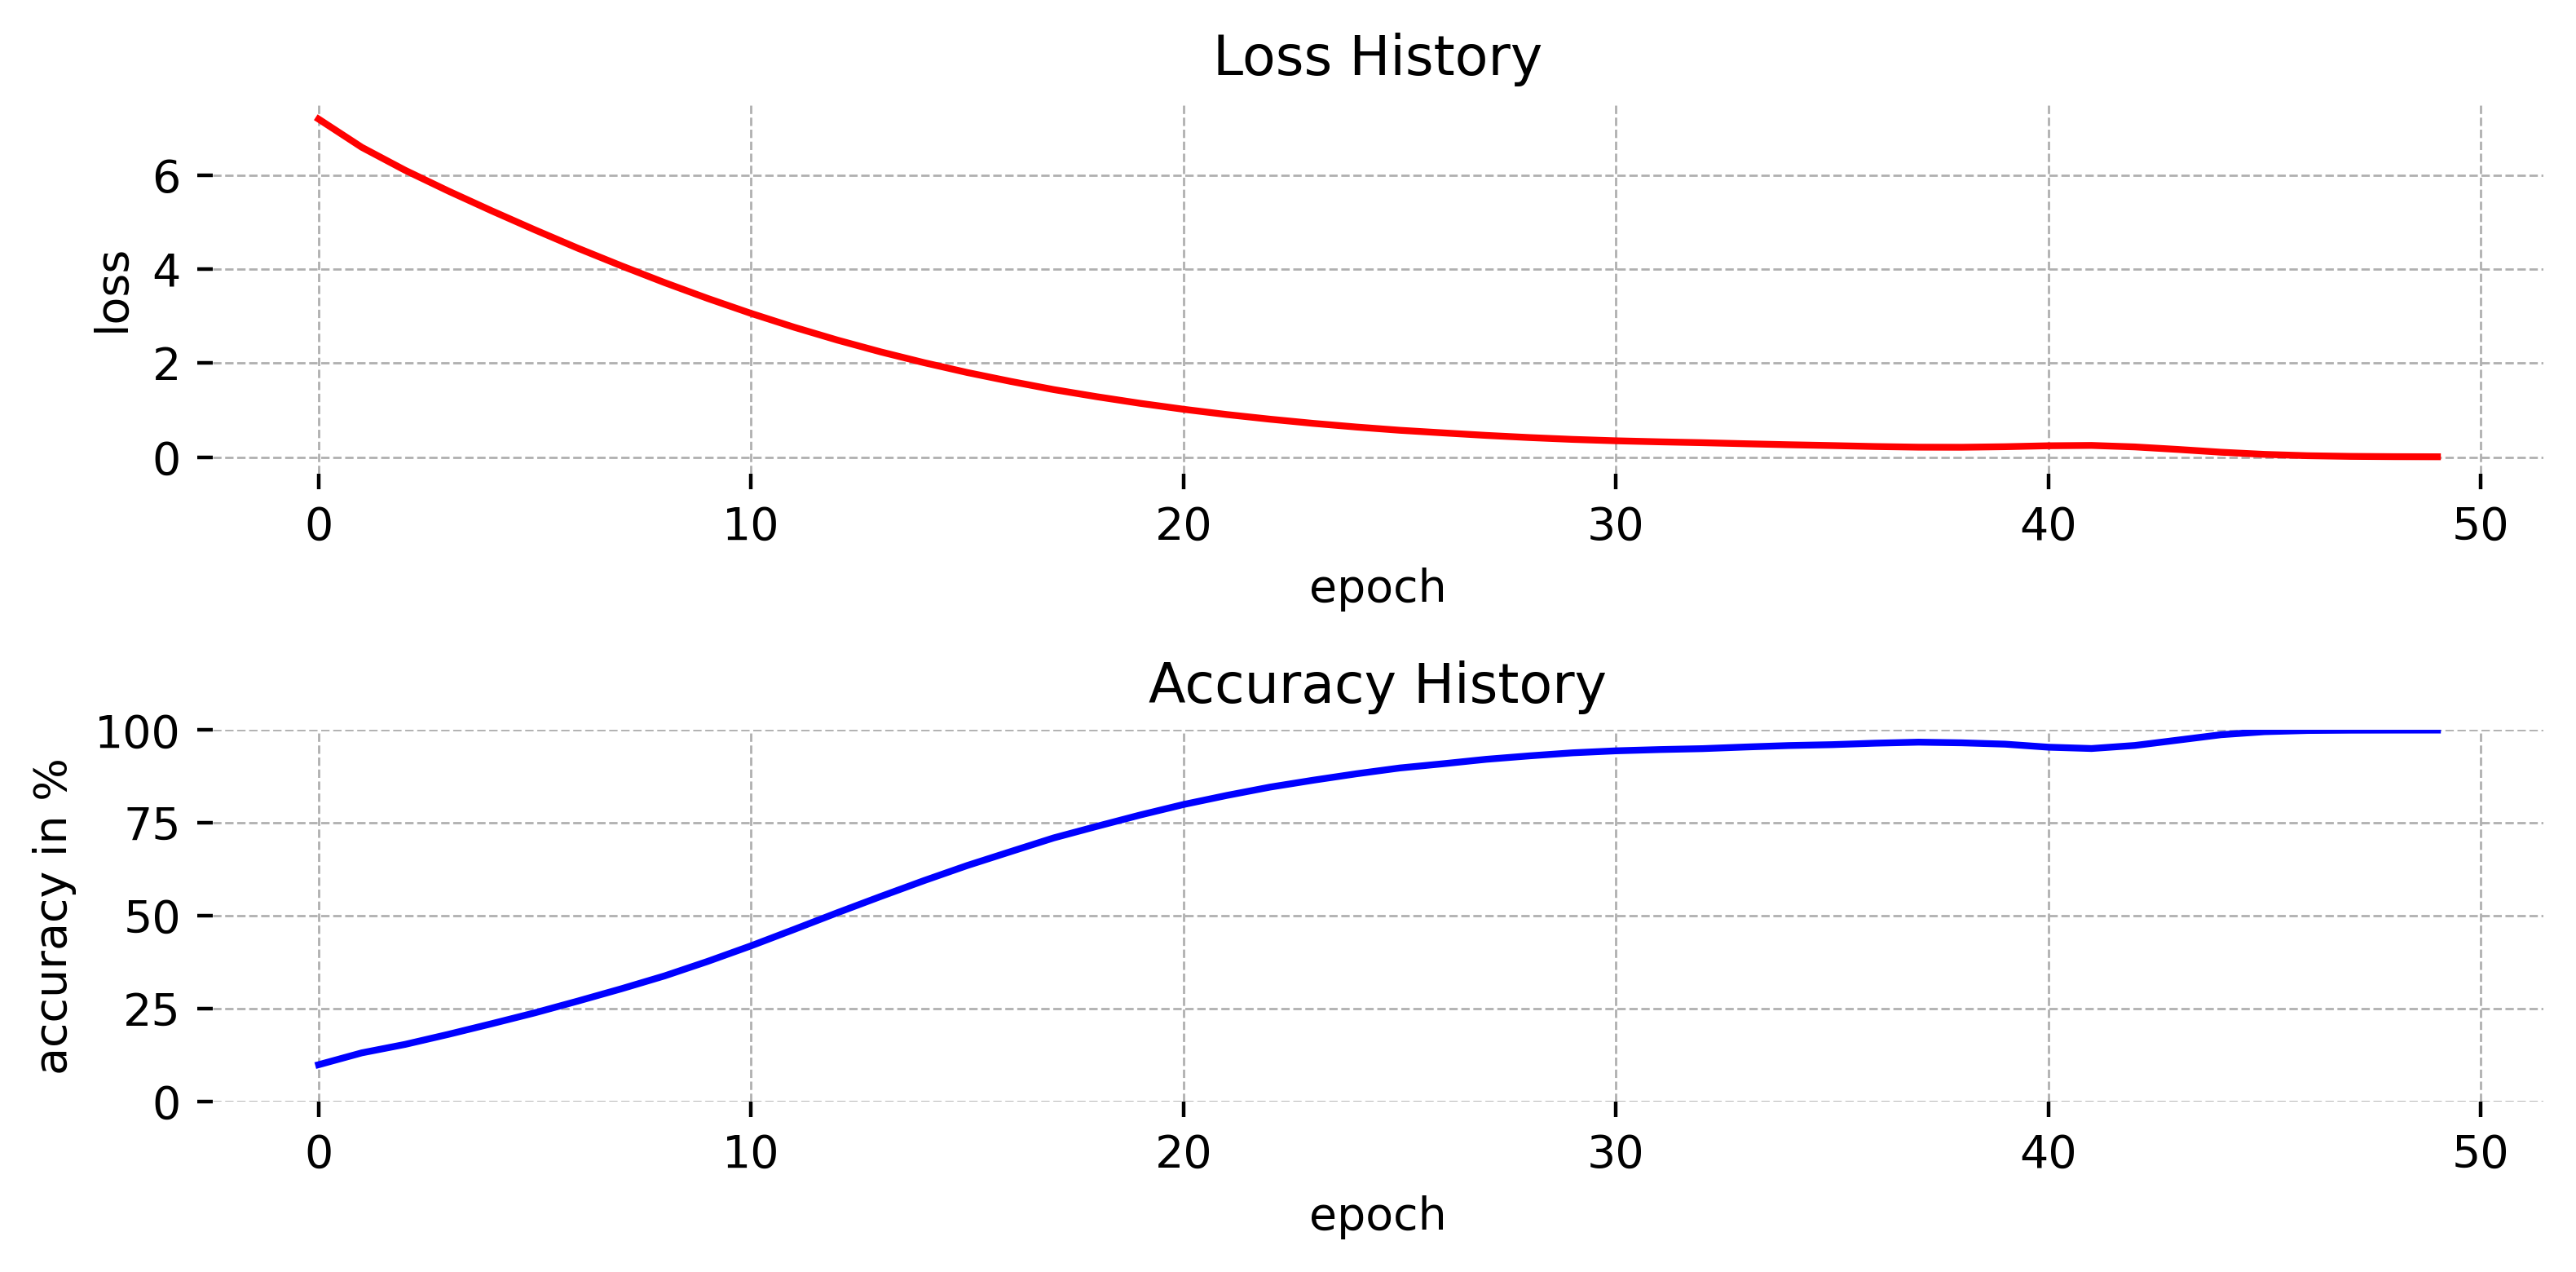

In [15]:
fit(model, optim, loader, epochs, device).plot()

## Embedding Visualization

Here we attempt to visualize the resulting embedding space. As the embedding dim is often bigger thant 3 dimension it is hard to visualize. In this type of scenario data scientists use a set of tools referred to as dimensionality reduction techniques. One of such as method is [t-SNE](https://jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf).

In the following cell, we apply the t-SNE method to every token of the vocabulary and reduce their embedding dimension to 2. This process will allow us to project the embeddings into a 2 dimensional scatter plot.

In [35]:
embedding = model.embedding.to("cpu")

vocab_emb = torch.empty((len(hp_cbow.vocab), emb_dim), dtype=torch.float32)
with torch.inference_mode():
    for word_id in range(len(hp_cbow.vocab)):
        word_x = torch.tensor([word_id], dtype=torch.long)
        vocab_emb[word_id] = embedding(word_x).view(1, -1)

reduced_vocab_emb = TSNE(n_components=2).fit_transform(vocab_emb.numpy())

/home/yliess/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/yliess/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


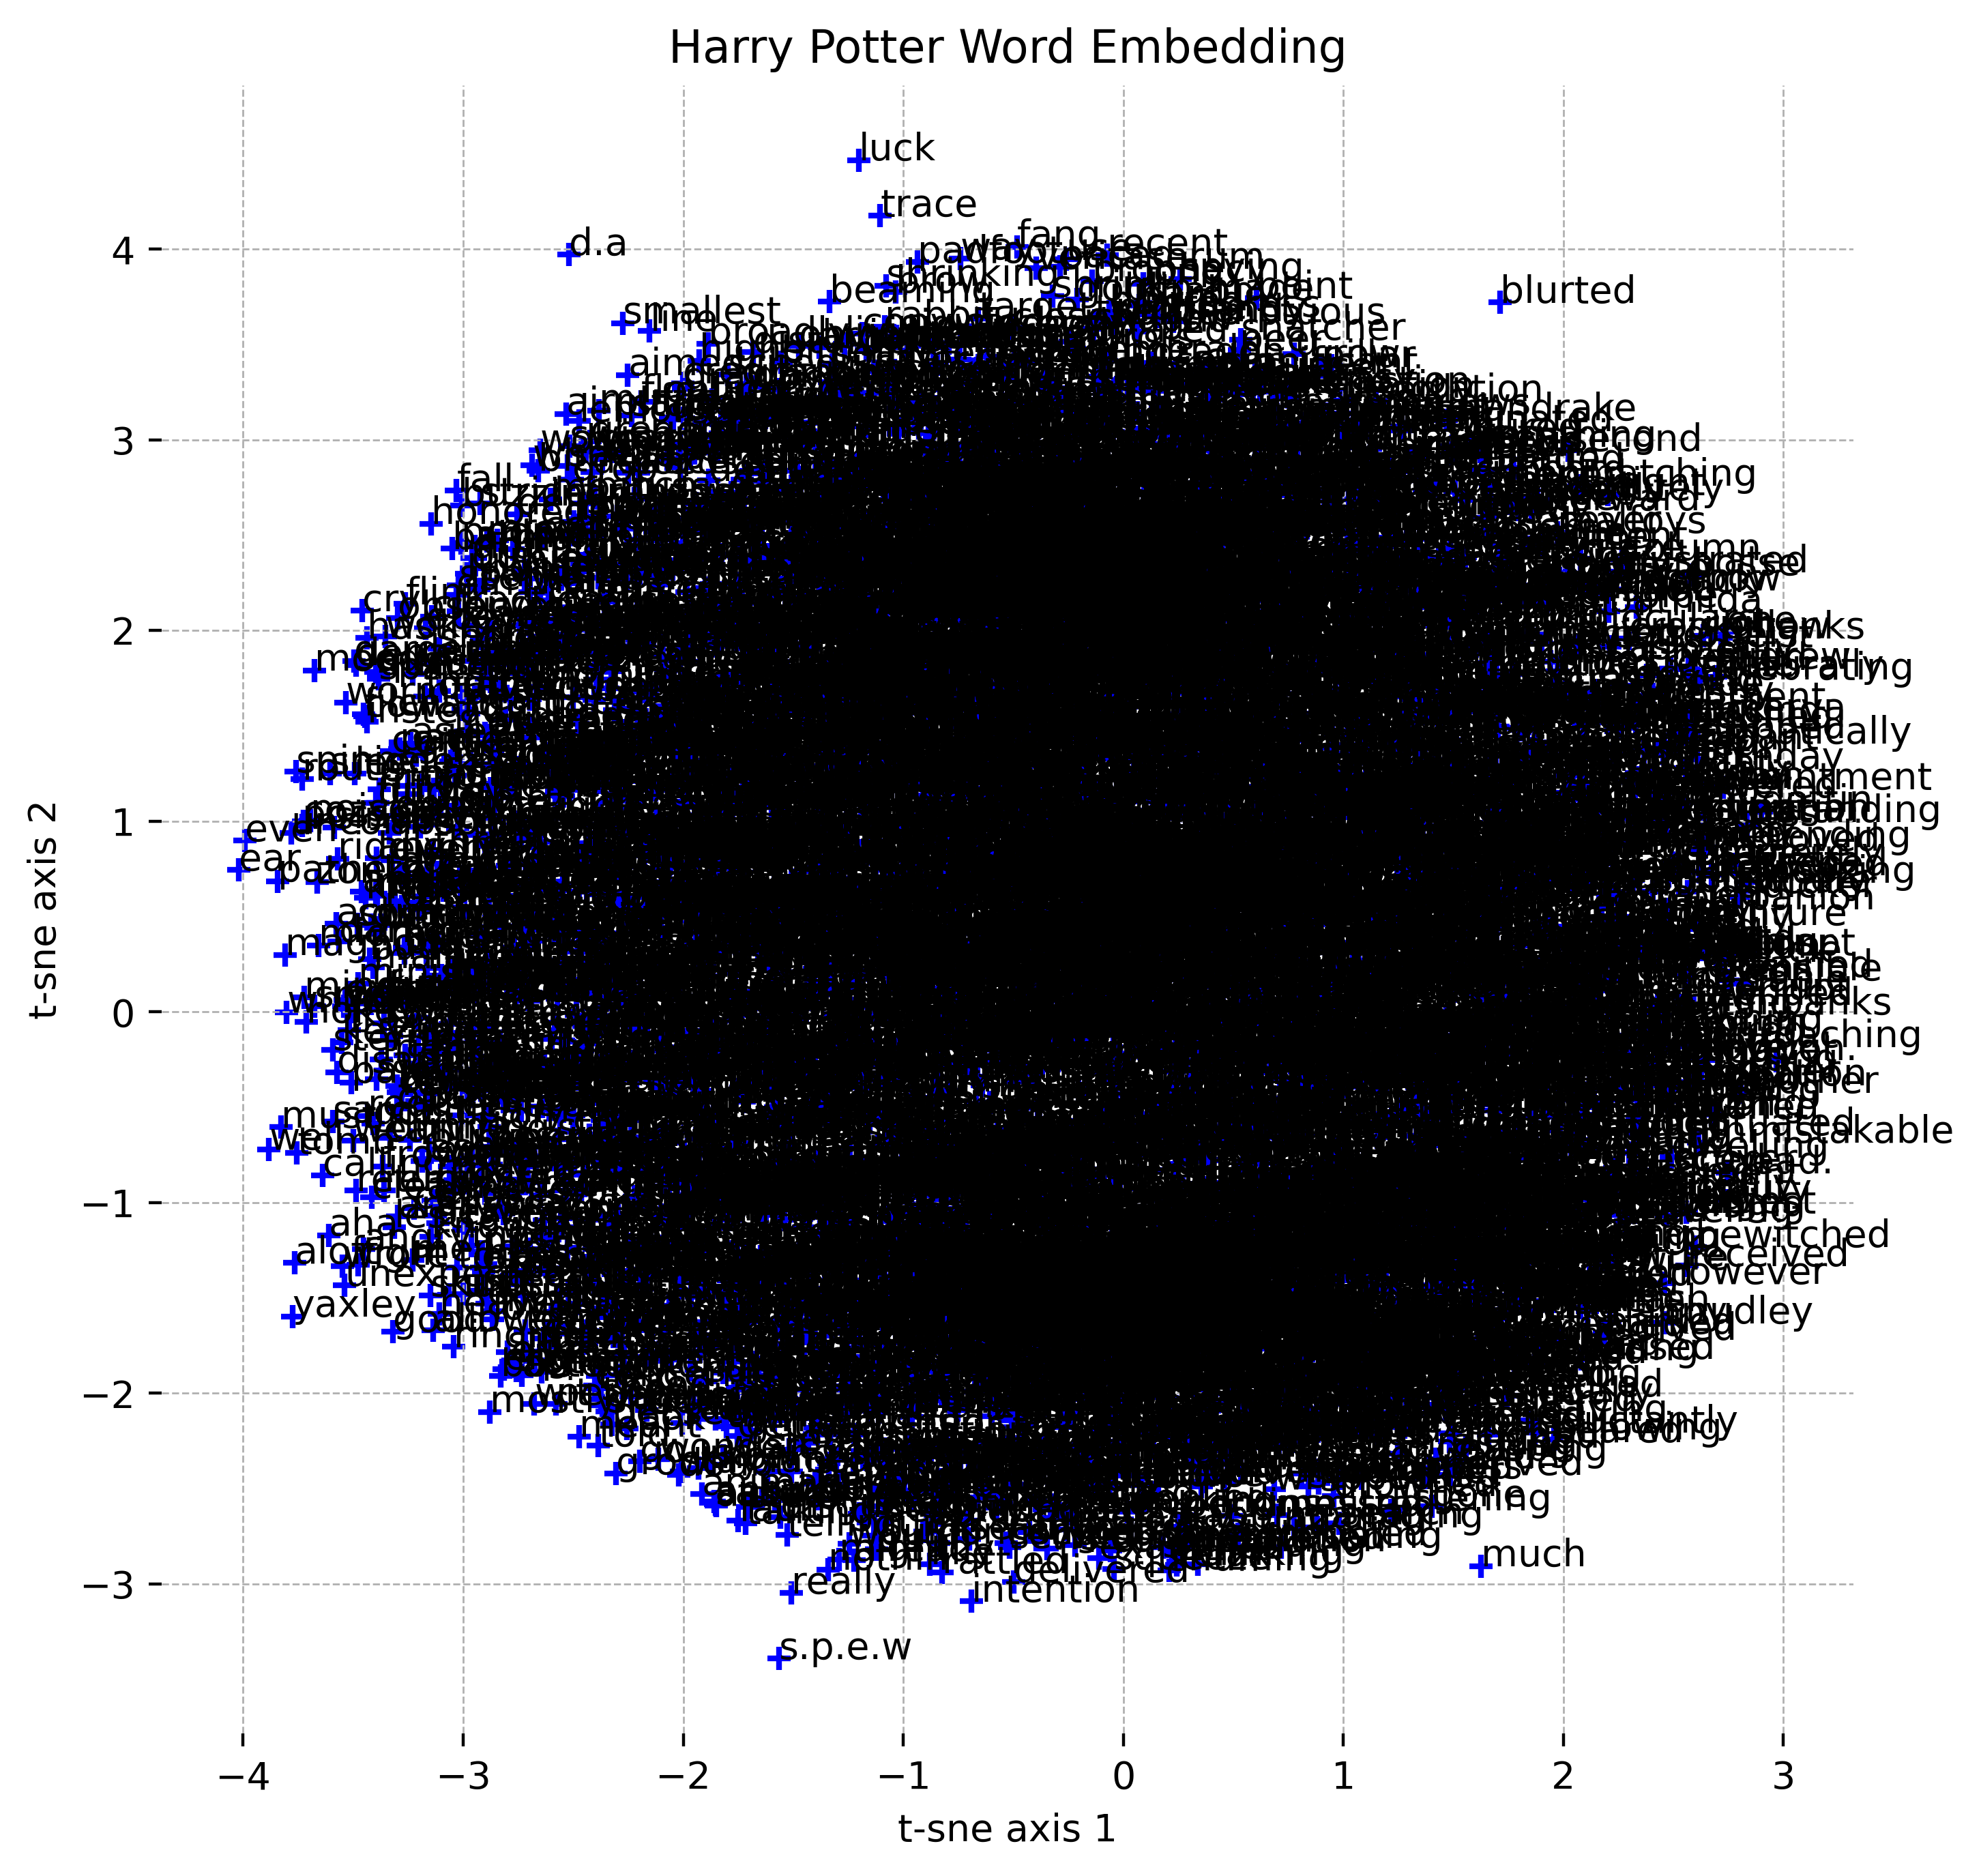

In [36]:
fig = plt.figure(figsize=(8, 8), dpi=400)
ax = fig.add_subplot(1, 1, 1)
ax.scatter(x=reduced_vocab_emb[1:, 0], y=reduced_vocab_emb[1:, 1], color="b", marker="+")
for i, word in hp_cbow.vocab._itos.items():
    if word == "<unk>": continue
    ax.annotate(word, reduced_vocab_emb[i])
ax.set_title("Harry Potter Word Embedding")
ax.set_xlabel("t-sne axis 1")
ax.set_ylabel("t-sne axis 2")
ax.grid(linestyle="--", linewidth=0.5)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_visible(False)
fig.canvas.draw()
plt.show()

## Closest Words

The trained embedding makes word with similar contexts close to each other and pushes others far away. As such we can mesure the closest relationship between every word of the dictionnary by mesure their distance. Many distances can be used such as the euclidean distance (used here), the cosine distance, and more. They all have downsides and advantages that will not be discussed here.

In [37]:
def closest_words(ref_word: str, top_k: int = 10) -> None:
    ref_idx = torch.tensor(hp_cbow.vocab.stoi(ref_word), dtype=torch.long)
    ref_embedding = model.embedding(ref_idx)

    word_distances = []
    pdist = PairwiseDistance()
    for word in hp_cbow.vocab._stoi.keys():
        if word in [ref_word, "<unk>"]: continue
        idx = torch.tensor(hp_cbow.vocab.stoi(word), dtype=torch.long)
        embedding = model.embedding(idx)
        word_distances.append((word, pdist(ref_embedding, embedding).item()))
    word_distances.sort(key=lambda wd: wd[1])

    print("------------------------------")
    print(f"Closest words for {ref_word}:")
    for i, (word, dist) in enumerate(word_distances[:top_k]):
        print(f"{i + 1:>2} - {word:<12} | {dist:.2e}")
    print("------------------------------")

In [19]:
closest_words("harry")

------------------------------
Closest words for harry:
 1 - ron          | 1.09e+00
 2 - certainly    | 1.13e+00
 3 - said         | 1.14e+00
 4 - anymore      | 1.15e+00
 5 - drowning     | 1.15e+00
 6 - blinked      | 1.15e+00
 7 - hermione     | 1.16e+00
 8 - briefly      | 1.16e+00
 9 - exasperated  | 1.16e+00
10 - lupin        | 1.16e+00
------------------------------


In [20]:
closest_words("wizzard")

------------------------------
Closest words for wizzard:
 1 - harry        | 8.90e-01
 2 - said         | 9.73e-01
 3 - security     | 1.01e+00
 4 - booming      | 1.02e+00
 5 - senior       | 1.03e+00
 6 - mistaken     | 1.03e+00
 7 - ron          | 1.03e+00
 8 - achieved     | 1.03e+00
 9 - orange       | 1.03e+00
10 - amazement    | 1.03e+00
------------------------------


In [21]:
closest_words("wand")

------------------------------
Closest words for wand:
 1 - harry        | 1.26e+00
 2 - gryffindor.  | 1.28e+00
 3 - hat          | 1.28e+00
 4 - hand         | 1.29e+00
 5 - ron          | 1.29e+00
 6 - boat         | 1.29e+00
 7 - narrowly     | 1.29e+00
 8 - surroundings | 1.30e+00
 9 - register     | 1.30e+00
10 - blade        | 1.30e+00
------------------------------


In [22]:
closest_words("griffondor")

------------------------------
Closest words for griffondor:
 1 - harry        | 8.90e-01
 2 - said         | 9.73e-01
 3 - security     | 1.01e+00
 4 - booming      | 1.02e+00
 5 - senior       | 1.03e+00
 6 - mistaken     | 1.03e+00
 7 - ron          | 1.03e+00
 8 - achieved     | 1.03e+00
 9 - orange       | 1.03e+00
10 - amazement    | 1.03e+00
------------------------------


In [23]:
closest_words("slytherin")

------------------------------
Closest words for slytherin:
 1 - harry        | 1.22e+00
 2 - gryffindor   | 1.23e+00
 3 - muggle       | 1.26e+00
 4 - ravenclaw    | 1.27e+00
 5 - captain      | 1.27e+00
 6 - reason       | 1.29e+00
 7 - staircase    | 1.29e+00
 8 - goggling     | 1.29e+00
 9 - hufflepuff   | 1.29e+00
10 - mistress     | 1.29e+00
------------------------------


In [24]:
closest_words("death")

------------------------------
Closest words for death:
 1 - false        | 1.26e+00
 2 - bellatrix    | 1.27e+00
 3 - mysterious   | 1.27e+00
 4 - harry        | 1.28e+00
 5 - business     | 1.28e+00
 6 - ravenclaw    | 1.28e+00
 7 - manner       | 1.28e+00
 8 - player       | 1.28e+00
 9 - badger       | 1.29e+00
10 - assistance   | 1.29e+00
------------------------------


In [25]:
closest_words("car")

------------------------------
Closest words for car:
 1 - harry        | 1.22e+00
 2 - demelza      | 1.24e+00
 3 - statement    | 1.27e+00
 4 - avery        | 1.28e+00
 5 - thunder      | 1.28e+00
 6 - ball         | 1.29e+00
 7 - quivered     | 1.29e+00
 8 - star         | 1.29e+00
 9 - narrow       | 1.29e+00
10 - wreckage     | 1.30e+00
------------------------------


## Word Arithmetic

By representing words as vectors, it naturally benefits from vector space operations. Thus, we can apply arithmetics operations to word and combine them in a meaningful manner.

In [26]:
def plus_minus(ref_word: str, plus_word: str, minus_word: str, top_k: int = 10) -> None:
    ref_idx = torch.tensor(hp_cbow.vocab.stoi(ref_word), dtype=torch.long)
    ref_embedding = model.embedding(ref_idx)

    plus_idx = torch.tensor(hp_cbow.vocab.stoi(plus_word), dtype=torch.long)
    plus_embedding = model.embedding(plus_idx)

    minus_idx = torch.tensor(hp_cbow.vocab.stoi(minus_word), dtype=torch.long)
    minus_embedding = model.embedding(minus_idx)

    op_embedding = ref_embedding + plus_embedding - minus_embedding

    word_distances = []
    pdist = PairwiseDistance()
    for word in hp_cbow.vocab._stoi.keys():
        if word in [ref_word, plus_word, minus_word, "<unk>"]: continue
        idx = torch.tensor(hp_cbow.vocab.stoi(word), dtype=torch.long)
        embedding = model.embedding(idx)
        word_distances.append((word, pdist(op_embedding, embedding).item()))
    word_distances.sort(key=lambda wd: wd[1])

    print("------------------------------")
    print(f"Closest words for {ref_word} + {plus_word} - {minus_word}:")
    for i, (word, dist) in enumerate(word_distances[:top_k]):
        print(f"{i + 1:>2} - {word:<12} | {dist:.2e}")
    print("------------------------------")

In [27]:
plus_minus("harry", "ginny", "hermione")

------------------------------
Closest words for harry + ginny - hermione:
 1 - glared       | 1.67e+00
 2 - test         | 1.68e+00
 3 - brightly     | 1.69e+00
 4 - captain      | 1.69e+00
 5 - flinched     | 1.69e+00
 6 - giving       | 1.70e+00
 7 - pit          | 1.70e+00
 8 - mister       | 1.70e+00
 9 - ron          | 1.70e+00
10 - music        | 1.70e+00
------------------------------


In [28]:
plus_minus("james", "lily", "child")

------------------------------
Closest words for james + lily - child:
 1 - prophecy     | 1.82e+00
 2 - harry        | 1.82e+00
 3 - muddy        | 1.83e+00
 4 - mistaken     | 1.83e+00
 5 - grudgingly   | 1.84e+00
 6 - indeed       | 1.84e+00
 7 - interrupt    | 1.84e+00
 8 - energy       | 1.84e+00
 9 - distinct     | 1.85e+00
10 - mandrake     | 1.85e+00
------------------------------


## Relationship Exploration

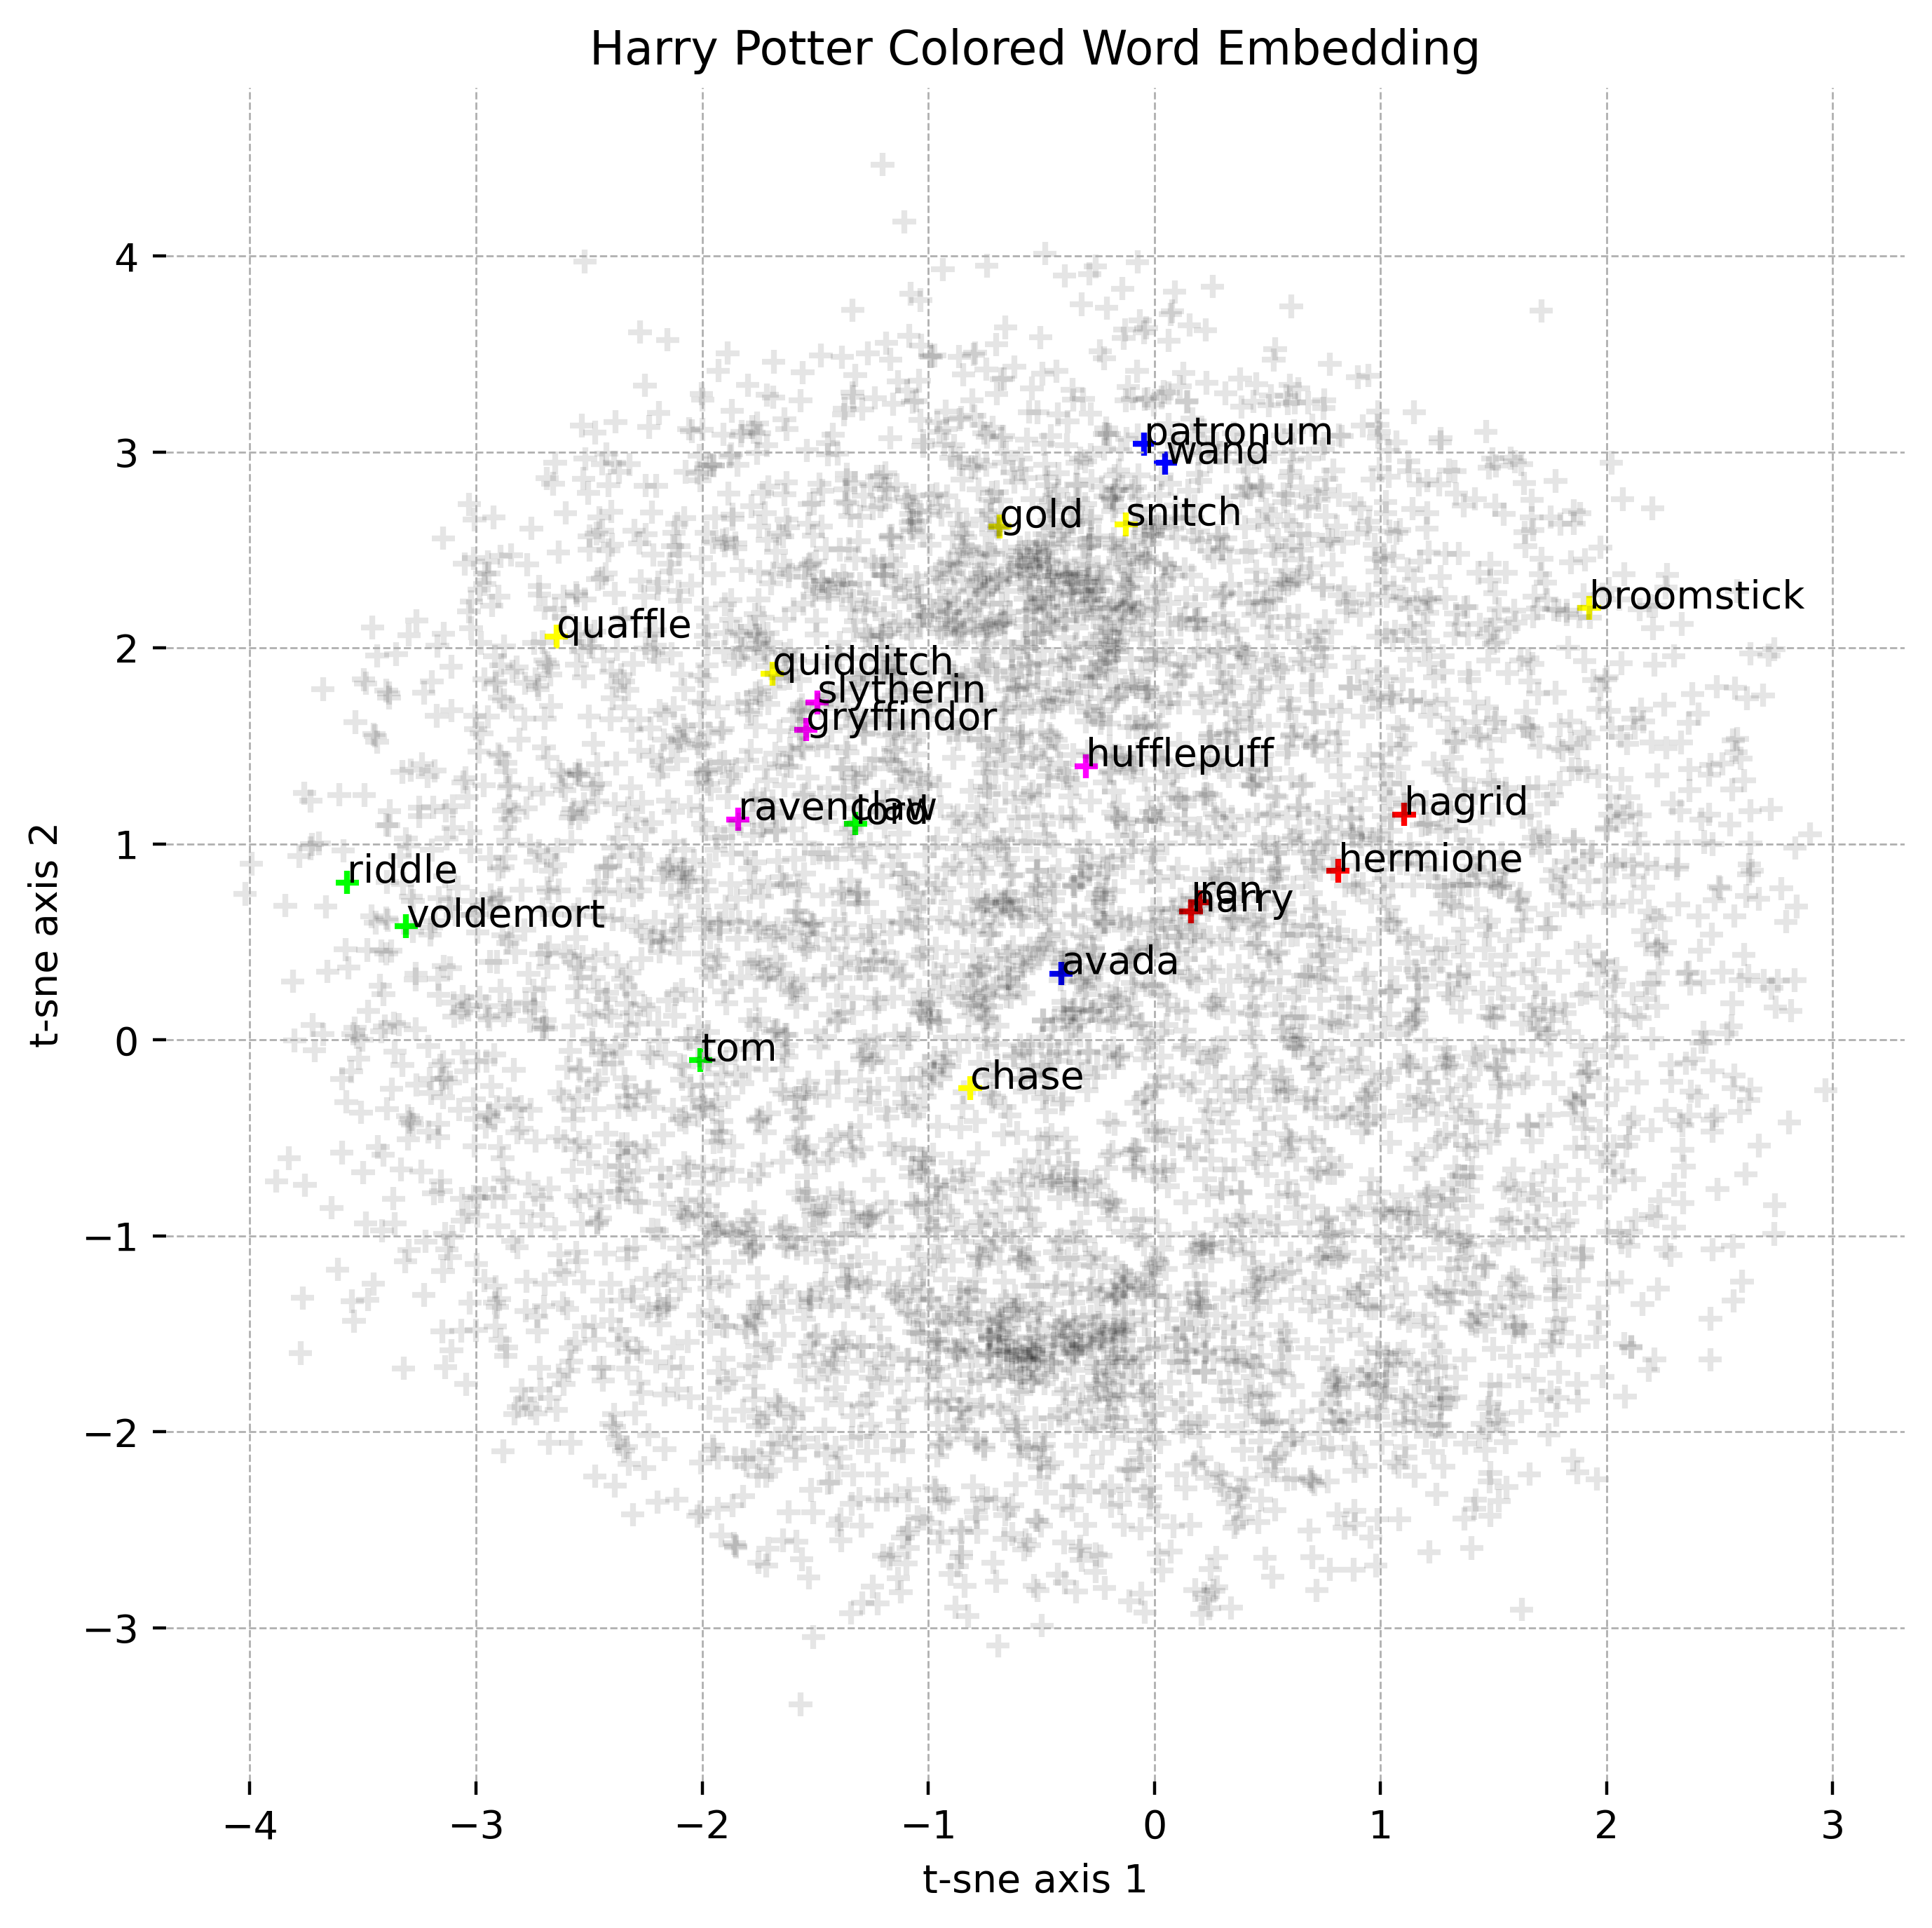

In [38]:
fig = plt.figure(figsize=(8, 8), dpi=400)
ax = fig.add_subplot(1, 1, 1)

friends   = ["harry", "ron", "hermione", "hagrid"]
voldemort = ["voldemort", "tom", "riddle", "lord"]
magic     = ["wand", "expelliarmus", "avada", "patronum", "leviosa"]
houses    = ["gryffindor", "ravenclaw", "hufflepuff", "slytherin"]
quidditch = ["quidditch", "quaffle", "chase", "broomstick", "gold", "snitch"]

c = []
for i, word in hp_cbow.vocab._itos.items():
    found = False
    if word == "<unk>"  : continue
    if word in friends  : found = True; c.append((1, 0, 0, 1))
    if word in voldemort: found = True; c.append((0, 1, 0, 1))
    if word in magic    : found = True; c.append((0, 0, 1, 1))
    if word in houses   : found = True; c.append((1, 0, 1, 1))
    if word in quidditch: found = True; c.append((1, 1, 0, 1))
    if found: ax.annotate(word, reduced_vocab_emb[i])
    else: c.append((0, 0, 0, 0.1))

ax.scatter(x=reduced_vocab_emb[1:, 0], y=reduced_vocab_emb[1:, 1], c=c, marker="+")
ax.set_title("Harry Potter Colored Word Embedding")
ax.set_xlabel("t-sne axis 1")
ax.set_ylabel("t-sne axis 2")
ax.grid(linestyle="--", linewidth=0.5)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_visible(False)
fig.canvas.draw()
plt.show()